<img src="https://d33wubrfki0l68.cloudfront.net/22691a3c3002324451ed99f4009de8aab761e1b7/d24da/public/images-original/stac-01.png"
     style="margin-right: 10px; width: 25%"/><img src="https://raw.githubusercontent.com/pydata/xarray/main/doc/_static/logos/Xarray_Logo_RGB_Final.png"
     style="margin-right: 10px; width: 25%"/>

# STAC

STAC (SpatioTemporal Asset Catalog) is an open standard designed to facilitate the discovery, search, and use of geospatial data. It defines a common metadata model and web API, allowing users to catalog, search, and access various types of geospatial data, such as satellite imagery, aerial photos, and other spatial datasets. STAC aims to improve interoperability between different data providers and users, making it easier to work with large volumes of geospatial information in a standardized way.

A STAC Catalog is the root document that provides links to Collections, Items, and other Catalogs, serving as an entry point to navigate the structure of geospatial data. A STAC Collection is a group of related Items that share common metadata, offering information about the dataset's spatial and temporal extent and linking to individual Items. A STAC Item represents a single geospatial asset, such as a satellite image or drone photograph, and includes metadata like acquisition time, location, and links to data files (Assets). An Asset is a data file associated with a STAC Item, including various types of data like images or metadata documents, each with a URL and metadata describing its type, format, and role.

To get to know the structure you can take a quick look at the EODC Data Catalogue:

https://services.eodc.eu/browser/#/?.language=en


Further you can look at the AI4SAR_SIG0 catalogue:

https://services.eodc.eu/browser/#/v1/collections/AI4SAR_SIG0


The database we will work with in this notebook is provided by the EODC. The European Open Data Center (EODC) is an organization that provides access to extensive Earth observation data and services, facilitating the management, processing, and analysis of geospatial information. EODC offers a variety of datasets, including satellite imagery from missions such as Sentinel and Landsat, which are essential for environmental monitoring, climate research, and other geospatial applications. 




# Exploring Data with STAC and Xarray

In this notebook, we will demonstrate how to use the STAC API in conjunction with open-source Python libraries to load data into *Xarray* via *odc-stac*. The objective of this notebook is to showcase the integration of data discovery (using STAC) and data analysis (using Xarray).

Xarray is an open-source Python library designed to handle multi-dimensional arrays and datasets, extending the capabilities of NumPy. It provides labeled arrays and datasets, enabling users to work with complex data structures like time series, climate data, and other scientific datasets. Xarray integrates seamlessly with other scientific libraries like Pandas and Dask, allowing for efficient data manipulation, analysis, and visualization.

## Import required packages

Before we import required packages we have to install ODC. The Open Data Cube (ODC) is an open-source project designed to facilitate the use of Earth observation data. It provides a scalable platform for managing, analyzing, and visualizing large volumes of geospatial data. We will use this package later on.

In [15]:
from IPython.display import clear_output

# This command lets you directly install ODC without using the terminal.
!pip install odc-stac

# Clear the output to hide the installation details
clear_output()

print("Installation completed.")


Installation completed.


In [16]:
#These are the important packages we first need to import 

import os
import json
from datetime import datetime
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import pystac
from pystac_client import Client
from odc import stac as odc_stac
from odc.geo.geobox import GeoBox
from affine import Affine

In [17]:
#The code here adjusts the width of the nootebook display container

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Create STAC client and connecting to the server

The API (Application Programmin Interface) we use connects us with the EODC database using STAC convention. If we open https://stac.eodc.eu/api/v1 in our browser we will see a JSON file including a set of links below "conformsTo" which describes the structure of the API for example how we filter through catalogues looking for items. Below "links" we will find the links to the catalogues themselves. This JSON file is basically the underlying structure for the catalogue we already opened before showing us the EODC web interface of the catalogue (https://services.eodc.eu/browser/#/?.language=en).


The AI4SAR collection we will work with includes a few items from Sentinel 1 for differnt times in the year 2023 nearby the area of Austria.

In [18]:
#This is how we access the AI4SAR collection via the stac_api

stac_api = "https://stac.eodc.eu/api/v1"
client = Client.open(stac_api)

collection_id="GFM"

In this notebook we want to take a look a the Copernicus Sentinel-1 data in the area of Pakistan in the year 2022 where a terrible flood took place. 

https://en.wikipedia.org/wiki/2022_Pakistan_floods

## Load STAC Items into xarray Dataset using odc.stac

Here we search for certain items in the AI4SAR_SIG0 collection, defining the area and time period.


In [19]:
collection_id="GFM"

bbox = [-180, -90, 180, 90]  # [lon_min, lat_min, lon_max, lat_max]
start_date = "2022-09-01"
end_date = "2022-09-07"

query = client.search(bbox=bbox,
                        collections=[collection_id],
                        datetime=f"{start_date}/{end_date}",
                        )
q_items = sorted(query.items(), key=lambda x: x.id)

In [20]:
print("\n","The length of the list of items is",len(q_items))


 The length of the list of items is 68


In the context of the GFM (Global Flood Monitoring) data, the bands variable specifies the types of data layers or assets you want to load from the dataset, with each "band" representing specific information or measurements. For instance, bands = ("refwater", "flood_extent") indicates an interest in loading two specific types of data: refwater, which likely represents reference water bodies used for comparison against current observations to identify changes or anomalies such as flooding, and flood_extent, which shows the areas currently flooded. When calling odc_stac.stac_load(q_items, bands=bands, ...), these specific data layers from the GFM dataset are loaded into an Xarray dataset, allowing for further analysis and visualization.

In [21]:
q_items[0].properties

{'gsd': 20,
 'datetime': '2022-09-01T01:08:42Z',
 'Equi7Tile': 'AS020M_E021N030T3',
 'blocksize': {'x': 512, 'y': 512},
 'proj:bbox': [2100000, 3000000, 2400000, 3300000],
 'proj:wkt2': 'PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["false_easting",4340913.84808],PARAMETER["false_northing",4812712.92347],PARAMETER["longitude_of_center",94.0],PARAMETER["latitude_of_center",47.0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]',
 'proj:shape': [15000, 15000],
 'constellation': 'sentinel-1',
 'proj:geometry': {'type': 'Polygon',
  'coordinates': [[[2100000.0, 3000000.0],
    [2100000.0, 3300000.0],
    [2400000.0, 3300000.0],
    [2400000.0, 3000000.0],
    [2100000.0, 3000000.0]]]},
 'proj:transform': [20, 0, 2100000, 0, -20, 3300000]}

In [22]:
q_items[0].assets

{'refwater': <Asset href=https://data.eodc.eu/collections/GFM_REFWATER/V03/EQUI7_AS020M/E021N030T3/REFERENCE_WATER_OUT_S1-_IW_GRDH_1S-V_20200901T131143_20210930T010902_MONTH-_------_----_V03.tif>,
 'flood_extent': <Asset href=https://data.eodc.eu/collections/GFM_LAYERS/flood_extent/AS020M/2022/09/01/ENSEMBLE_FLOOD_20220901T010842_VV_AS020M_E021N030T3.tif>}

In [23]:
bands = ("refwater", "flood_extent")
crs = "EPSG:4326"  # This may need to be adapted based on your CRS
bbox = [-60, -30, 60, 30]
res =  0.02

sig0_ds = odc_stac.stac_load(q_items,
                        bands=bands,
                        crs=crs,
                        resolution=res,
                        bbox=bbox,
                        use_overviews=False,
                        )


In [24]:
sig0_ds

<xarray.Dataset> Size: 792MB
Dimensions:       (latitude: 3000, longitude: 6000, time: 22)
Coordinates:
  * latitude      (latitude) float64 24kB 29.99 29.97 29.95 ... -29.97 -29.99
  * longitude     (longitude) float64 48kB -59.99 -59.97 -59.95 ... 59.97 59.99
    spatial_ref   int32 4B 4326
  * time          (time) datetime64[ns] 176B 2022-09-01T01:08:42 ... 2022-09-...
Data variables:
    refwater      (time, latitude, longitude) uint8 396MB 255 255 ... 255 255
    flood_extent  (time, latitude, longitude) uint8 396MB 255 255 ... 255 255

In [32]:
#Here we take a look at the smallest and biggest value in the array

for i in range(22):

    print('min:',sig0_ds.refwater[i,:,:].min().values,'max:',sig0_ds.refwater[i,:,:].max().values)

min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255
min: 255 max: 255


In [29]:
sig0_ds.flood_extent[0,:,:]

print('something')

<xarray.DataArray 'flood_extent' (latitude: 3000, longitude: 6000)> Size: 18MB
array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
Coordinates:
  * latitude     (latitude) float64 24kB 29.99 29.97 29.95 ... -29.97 -29.99
  * longitude    (longitude) float64 48kB -59.99 -59.97 -59.95 ... 59.97 59.99
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2022-09-01T01:08:42
Attributes:
    nodata:   255

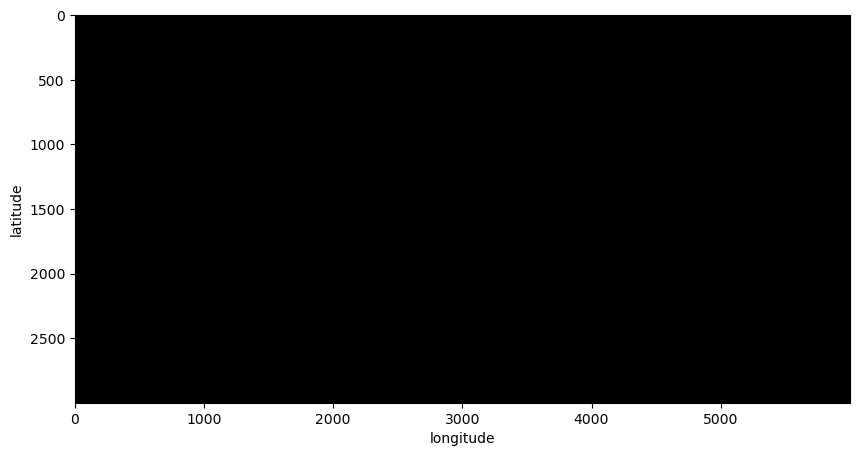

In [ ]:
flood_ext1=sig0_ds.flood_extent[0,:,:]
plt.figure(figsize=(10,6))
plt.imshow(flood_ext1, cmap='gray')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [ ]:
def scale_image(arr, nodata, vmin=None, vmax=None):
    
    v_idx = arr!=nodata
    
    v = arr[v_idx]

    if vmin is None:
        
        vmin = np.min(v)
    if vmax is None:
        vmax = np.max(v)
    
    out = np.copy(arr)
    # scale between 1 and 255 and leave 0 for nodata
    out = (out-vmin) * (254/(vmax-vmin)) + 1
    out[~v_idx] = 0

    return out.astype(np.uint8)

In [ ]:
#Here we visualize the VV polarization values for the 22 moments in time we have

fig1 = plt.figure(figsize=(18, 6))
fig1.suptitle('GFM floodextent', fontsize=16, y=1.05)
nodata = -9999

for i in range(3):
    
    img = sig0_ds.VV[i,:,:].to_numpy()
    name = q_items[i].id

    gray_img = scale_image(img, nodata, vmin=-170, vmax=20)

    ax = fig1.add_subplot(1, 3, i+1)
    ax.set_title(name)
    ax.imshow(gray_img, cmap='gray')


plt.tight_layout()

AttributeError: 'Dataset' object has no attribute 'VV'

<Figure size 1800x600 with 0 Axes>